### Inputs 

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pickle

<IPython.core.display.Javascript object>

### Constants

In [3]:
run = 3
input_dir = "./input/16Jan/".format(run)
output_dir = "./output/run{}/e_resolution/".format(run)
ub_tag = "MicroBooNE, In Progress"

per1 = 50 - 45  # 68.27/2            # 1sigma stat boundaries
per2 = 50 + 45  # 68.27/2
per21 = 50 - 95.45 / 2
per22 = 50 + 95.45 / 2
persig1 = 50 - 68.27 / 2
persig2 = 50 + 68.27 / 2

<IPython.core.display.Javascript object>

### Functions

In [4]:
def cosmic_angles(mom_x, mom_y, mom_z):
    theta = np.arctan2(np.sqrt(np.square(mom_x) + np.square(mom_y)), mom_z)
    phi = np.arctan2(mom_y, mom_x)
    return [theta, phi]


# should return resolution per bin
def getResolution(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    percentiles_arr = []

    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi
    for i in range(1, len(x_edges)):
        ax.hist(
            data_diff[bin_id == i],
            bins=50,
            range=np.percentile(data_diff, [per21, per22]),
            histtype="step",
        )
        percentiles = np.percentile(
            data_diff[bin_id == i], [per1, persig1, 50, persig2, per2]
        )
        print(
            round(10 * mids[i - 1]) / 10,
            "\t",
            np.median(data_y[bin_id == i]),
            "\t",
            percentiles[[0, 2, 4]],
            "\t",
            (percentiles[-1] - percentiles[0]) / 2,
        )
        if periodic:
            percentiles /= 180 / np.pi
            mean.append(mids[i - 1] / (180 / np.pi) + percentiles[2])
        else:
            mean.append(mids[i - 1] + percentiles[2])
        err.append([percentiles[2] - percentiles[0], percentiles[4] - percentiles[2]])
        percentiles_arr.append(percentiles)
    if periodic:
        mids /= 180 / np.pi
    quants = np.array(percentiles_arr).T
    return mids, mean, err, quants


## make the one plot that will describe the resolution:
def getResolution2(data_x, data_y, x_edges, bin_i, periodic=False):
    mean = []
    err = []
    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi

    percentiles = np.percentile(data_diff[bin_id == bin_i], [per1, 50, per2])

    print(
        round(mids[bin_i - 1] * 10) / 10,
        "\t",
        np.median(data_y[bin_id == bin_i]),
        "\t",
        percentiles,
        "\t",
        (percentiles[-1] - percentiles[0]) / 2,
    )
    if periodic:
        percentiles /= 180 / np.pi
        mean = mids[bin_i - 1] / (180 / np.pi) + percentiles[1]
    else:
        mean = mids[bin_i - 1] + percentiles[1]
    err = [percentiles[0], percentiles[2]]

    if periodic:
        mids /= 180 / np.pi
    return mids[bin_i - 1], percentiles[1], err, data_diff[bin_id == bin_i]

<IPython.core.display.Javascript object>

### Load data

In [5]:
data = pickle.load(open(input_dir + "after_training_run{}.pckl".format(run), "rb"))
data = data["nue"]
daughters = data["daughters"].query("e_candidate & select & nueccinc").copy()

<IPython.core.display.Javascript object>

In [6]:
# create some fields, such as true phi, theta and start end distance
temp = daughters[
    [
        "true_nu_vtx_sce_x",
        "true_nu_vtx_sce_y",
        "true_nu_vtx_sce_z",
        "backtracked_sce_start_x",
        "backtracked_sce_start_y",
        "backtracked_sce_start_z",
    ]
].values.T
daughters["true_shr_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
temp = daughters[
    [
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
        "shr_tkfit_start_x_v",
        "shr_tkfit_start_y_v",
        "shr_tkfit_start_z_v",
    ]
].values.T
daughters["tkfit_shr_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
temp = daughters[
    [
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
        "shr_start_x_v",
        "shr_start_y_v",
        "shr_start_z_v",
    ]
].values.T
daughters["shr_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
temp = daughters[
    [
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
        "trk_start_x_v",
        "trk_start_y_v",
        "trk_start_z_v",
    ]
].values.T
daughters["trk_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
cols = ["backtracked_px", "backtracked_py", "backtracked_pz"]
daughters["backtracked_theta"], daughters["backtracked_phi"] = cosmic_angles(
    *daughters[cols].T.values
)

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


<IPython.core.display.Javascript object>

In [7]:
[k for k in data["fields"] if "_x_v" in k]

['shr_start_x_v',
 'shr_tkfit_start_x_v',
 'shr_spacepoint_start_x_v',
 'shr_hits_start_U_x_v',
 'shr_hits_start_V_x_v',
 'shr_hits_start_Y_x_v',
 'trk_dir_x_v',
 'trk_start_x_v',
 'trk_sce_start_x_v',
 'trk_end_x_v',
 'trk_sce_end_x_v']

<IPython.core.display.Javascript object>

In [8]:
[k for k in data["daughters"].keys() if "_x_v" in k]

['trk_sce_end_x_v',
 'trk_sce_start_x_v',
 'trk_start_x_v',
 'shr_tkfit_start_x_v',
 'shr_start_x_v']

<IPython.core.display.Javascript object>

### Plots

In [9]:
daughters["backtracked_pdg"].abs().value_counts()

11     18200
22        24
0          7
211        4
Name: backtracked_pdg, dtype: int64

<IPython.core.display.Javascript object>

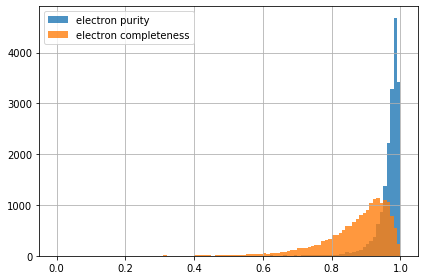

<IPython.core.display.Javascript object>

In [10]:
# Completeness and Purity of the leading electron candidate
fig, ax = plt.subplots()
daughters["backtracked_purity"].hist(
    bins=100, range=(0, 1), ax=ax, label="electron purity", alpha=0.8
)
daughters["backtracked_completeness"].hist(
    bins=100, range=(0, 1), ax=ax, label="electron completeness", alpha=0.8
)
ax.legend()
fig.tight_layout()

In [11]:
# Completeness and purity of the summed showers
daughters["trk_calo_energy_y_v"].describe()

count    1.823500e+04
mean     1.772405e+13
std      1.936527e+15
min      2.061444e+01
25%      8.587884e+02
50%      2.755747e+03
75%      1.296093e+04
max      2.555828e+17
Name: trk_calo_energy_y_v, dtype: float64

<IPython.core.display.Javascript object>

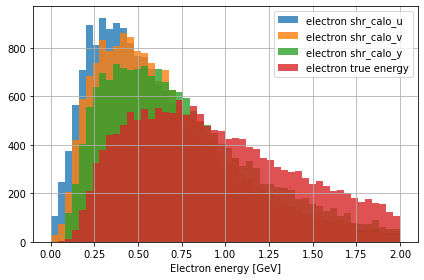

<IPython.core.display.Javascript object>

In [12]:
# Calorimetric energy comparison
fig, ax = plt.subplots()
daughters.eval("shr_energy_u_v/1000").hist(
    bins=50, range=(0, 2), ax=ax, label="electron shr_calo_u", alpha=0.8
)
daughters.eval("shr_energy_v_v/1000").hist(
    bins=50, range=(0, 2), ax=ax, label="electron shr_calo_v", alpha=0.8
)
daughters.eval("shr_energy_y_v/1000").hist(
    bins=50, range=(0, 2), ax=ax, label="electron shr_calo_y", alpha=0.8
)
(daughters["backtracked_e"]).hist(
    bins=50, range=(0, 2), ax=ax, label="electron true energy", alpha=0.8
)
ax.set_xlabel("Electron energy [GeV]")
ax.legend()
fig.tight_layout()

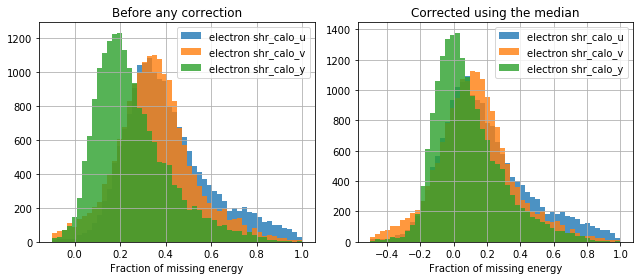

<IPython.core.display.Javascript object>

In [13]:
# Calorimetric energy comparison
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
daughters.eval("(backtracked_e - shr_energy_u_v/1000)/backtracked_e").hist(
    bins=50, range=(-0.1, 1), ax=ax[0], label="electron shr_calo_u", alpha=0.8
)
daughters.eval("(backtracked_e - shr_energy_v_v/1000)/backtracked_e").hist(
    bins=50, range=(-0.1, 1), ax=ax[0], label="electron shr_calo_v", alpha=0.8
)
daughters.eval("(backtracked_e - shr_energy_y_v/1000)/backtracked_e").hist(
    bins=50, range=(-0.1, 1), ax=ax[0], label="electron shr_calo_y", alpha=0.8
)
ax[0].set_title("Before any correction")
ax[0].set_xlabel("Fraction of missing energy")
ax[0].legend()

# after correction
corr_u = (
    daughters.eval("(backtracked_e - shr_energy_u_v/1000)/backtracked_e").median() + 1
)
corr_v = (
    daughters.eval("(backtracked_e - shr_energy_v_v/1000)/backtracked_e").median() + 1
)
corr_y = (
    daughters.eval("(backtracked_e - shr_energy_y_v/1000)/backtracked_e").median() + 1
)
daughters.eval("(backtracked_e - shr_energy_u_v/1000*@corr_u)/backtracked_e").hist(
    bins=50, range=(-0.5, 1), ax=ax[1], label="electron shr_calo_u", alpha=0.8
)
daughters.eval("(backtracked_e - shr_energy_v_v/1000*@corr_v)/backtracked_e").hist(
    bins=50, range=(-0.5, 1), ax=ax[1], label="electron shr_calo_v", alpha=0.8
)
daughters.eval("(backtracked_e - shr_energy_y_v/1000*@corr_y)/backtracked_e").hist(
    bins=50, range=(-0.5, 1), ax=ax[1], label="electron shr_calo_y", alpha=0.8
)
ax[1].set_title("Corrected using the median")
ax[1].set_xlabel("Fraction of missing energy")
ax[1].legend()
fig.tight_layout()
fig.savefig("test.pdf")

In [14]:
corr_u
corr_v
corr_y

1.219811111688614

<IPython.core.display.Javascript object>

In [15]:
# create some fields, such as true phi, theta and start end distance
temp = daughters[
    [
        "true_nu_vtx_sce_x",
        "true_nu_vtx_sce_y",
        "true_nu_vtx_sce_z",
        "backtracked_sce_start_x",
        "backtracked_sce_start_y",
        "backtracked_sce_start_z",
    ]
].values.T
daughters["true_shr_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
temp = daughters[
    [
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
        "shr_tkfit_start_x_v",
        "shr_tkfit_start_y_v",
        "shr_tkfit_start_z_v",
    ]
].values.T
daughters["tkfit_shr_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
temp = daughters[
    [
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
        "shr_start_x_v",
        "shr_start_y_v",
        "shr_start_z_v",
    ]
].values.T
daughters["shr_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
temp = daughters[
    [
        "reco_nu_vtx_x",
        "reco_nu_vtx_y",
        "reco_nu_vtx_z",
        "trk_start_x_v",
        "trk_start_y_v",
        "trk_start_z_v",
    ]
].values.T
daughters["trk_distance"] = np.linalg.norm(temp[0:3] - temp[3:6], axis=0)
cols = ["backtracked_px", "backtracked_py", "backtracked_pz"]
daughters["backtracked_theta"], daughters["backtracked_phi"] = cosmic_angles(
    *daughters[cols].T.values
)

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


<IPython.core.display.Javascript object>

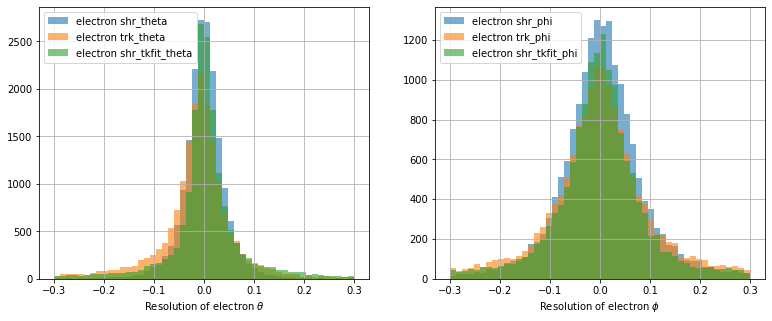

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))

daughters.eval("backtracked_theta - shr_theta_v").hist(
    bins=50, range=(-0.3, 0.3), ax=ax[0], label="electron shr_theta", alpha=0.6
)
daughters.eval("backtracked_theta - trk_theta_v").hist(
    bins=50, range=(-0.3, 0.3), ax=ax[0], label="electron trk_theta", alpha=0.6
)
daughters.eval("backtracked_theta - shr_tkfit_theta_v").hist(
    bins=50, range=(-0.3, 0.3), ax=ax[0], label="electron shr_tkfit_theta", alpha=0.6
)

daughters.eval("backtracked_phi - shr_phi_v").hist(
    bins=50, range=(-0.3, 0.3), ax=ax[1], label="electron shr_phi", alpha=0.6
)
daughters.eval("backtracked_phi - trk_phi_v").hist(
    bins=50, range=(-0.3, 0.3), ax=ax[1], label="electron trk_phi", alpha=0.6
)
daughters.eval("backtracked_phi - shr_tkfit_phi_v").hist(
    bins=50, range=(-0.3, 0.3), ax=ax[1], label="electron shr_tkfit_phi", alpha=0.6
)

ax[0].set_xlabel(r"Resolution of electron $\theta$")
ax[1].set_xlabel(r"Resolution of electron $\phi$")
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")

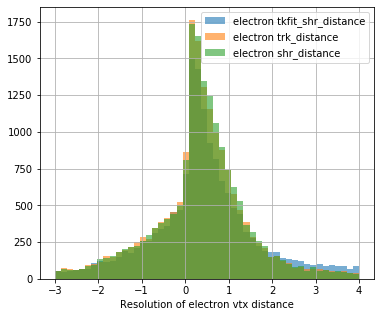

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 5))

daughters.eval("tkfit_shr_distance - true_shr_distance").hist(
    bins=50, range=(-3, 4), ax=ax, label="electron tkfit_shr_distance", alpha=0.6
)
daughters.eval("trk_distance - true_shr_distance").hist(
    bins=50, range=(-3, 4), ax=ax, label="electron trk_distance", alpha=0.6
)
daughters.eval("shr_distance - true_shr_distance").hist(
    bins=50, range=(-3, 4), ax=ax, label="electron shr_distance", alpha=0.6
)

ax.set_xlabel(r"Resolution of electron vtx distance")
ax.legend(loc="upper right")

### Resolution for real


Energy
0.1 	 0.147331 	 [-0.06580073 -0.01884909  0.01610101] 	 0.040950870886445036
0.3 	 0.25095275 	 [-0.16089532 -0.05127135  0.01751336] 	 0.08920433968305586
0.5 	 0.3937117 	 [-0.28490928 -0.09592757 -0.00830987] 	 0.1382997065782547
0.7 	 0.545876 	 [-0.42042878 -0.14515162 -0.02545767] 	 0.19748555719852445
0.9 	 0.6955974 	 [-0.51375579 -0.19353771 -0.04129435] 	 0.23623071759939188
1.1 	 0.8467858 	 [-0.65184528 -0.24802181 -0.05734946] 	 0.2972479104995727
1.3 	 0.9772513 	 [-0.78593538 -0.31589371 -0.09087341] 	 0.3475309833884239
1.5 	 1.1300713 	 [-0.87458546 -0.36979663 -0.13095393] 	 0.37181576490402213
1.7 	 1.2736139 	 [-1.01510502 -0.41523618 -0.14358718] 	 0.43575891554355617
1.9 	 1.4176558 	 [-1.1410302  -0.47373378 -0.18279109] 	 0.4791195571422577

Theta
9.0 	 0.22887754 	 [-2.91917505  0.24962293  4.72912519] 	 3.8241501212120053
26.7 	 0.44286212 	 [-3.50065773 -0.03789389  3.14597702] 	 3.3233173727989187
44.3 	 0.74439245 	 [-4.40425644 -0.17942907  3.5689

FileNotFoundError: [Errno 2] No such file or directory: './output/run3/e_resolution/resolution.pdf'

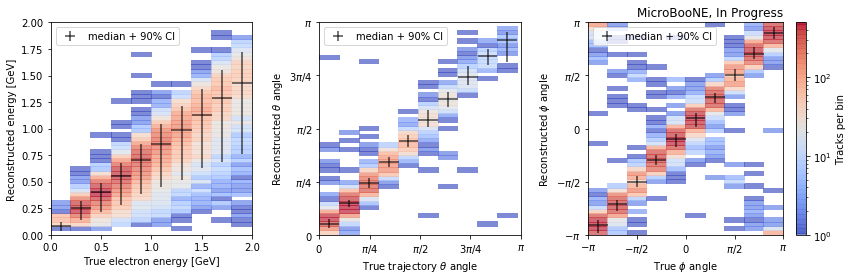

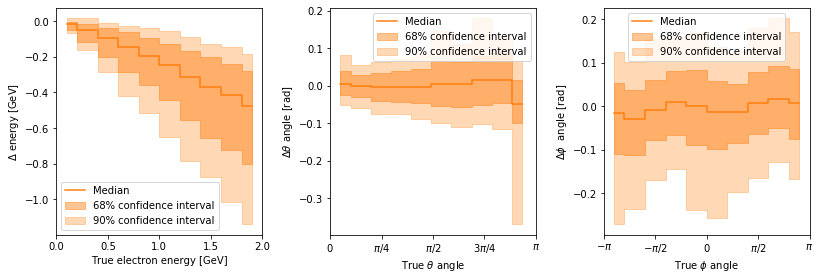

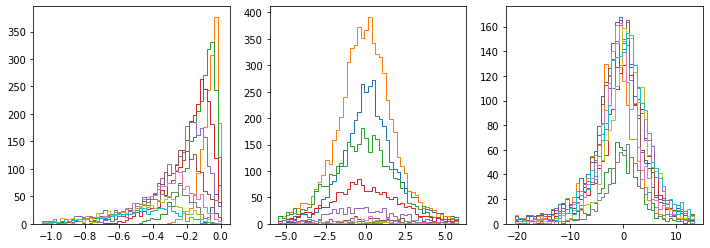

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(
    ncols=3, figsize=(12, 4), gridspec_kw={"width_ratios": [4, 4, 4.85]}
)
fig_res, ax_res = plt.subplots(ncols=3, figsize=(11.5, 4))
fig2, ax2 = plt.subplots(ncols=3, figsize=(12, 4))
n_x = 10
n_y = 50

print("\nEnergy")
y_max = 2
fld_mc, fld_reco = "backtracked_e", "shr_energy_y_v/1000"
h, x_edges, y_edges, im = ax[0].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((0, y_max), (0, y_max)),
)
ax[0].set_xlabel("True electron energy [GeV]")
ax[0].set_ylabel("Reconstructed energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[0]
)
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")

ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("True electron energy [GeV]")
ax_res[0].set_ylabel(r"$\Delta$ energy [GeV]")
ax_res[0].set_xlim(0, y_max)
ax_res[0].legend()

print("\nTheta")
fld_mc, fld_reco = "backtracked_theta", "shr_theta_v"
h, x_edges, y_edges, im = ax[1].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[1].set_xticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
ax[1].set_xticklabels([r"$0$", r"$\pi/4$", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
ax[1].set_yticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
ax[1].set_yticklabels([r"$0$", r"$\pi/4$", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
ax[1].set_xlabel(r"True trajectory $\theta$ angle")
ax[1].set_ylabel(r"Reconstructed $\theta$ angle")
ax[1].set_ylim(0, np.pi)
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[1], periodic=True
)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")


ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
ax_res[1].set_xticklabels([r"$0$", r"$\pi/4$", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
ax_res[1].set_xlabel(r"True $\theta$ angle")
ax_res[1].set_ylabel(r"$\Delta \theta$ angle [rad]")
ax_res[1].set_xlim(0, np.pi)
ax_res[1].legend()

print("\nPhi")
fld_mc, fld_reco = "backtracked_phi", "shr_phi_v"
h, x_edges, y_edges, im = ax[2].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[2].set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax[2].set_xticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax[2].set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax[2].set_yticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax[2].set_xlabel(r"True $\phi$ angle")
ax[2].set_ylabel(r"Reconstructed $\phi$ angle")
ax[2].set_ylim(-np.pi, np.pi)
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[2], periodic=True
)
ax[2].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[2].legend(loc="upper left")
ax[2].set_title(ub_tag, loc="right")

ax_res[2].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[2].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[2].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[2].set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax_res[2].set_xticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax_res[2].set_xlabel(r"True $\phi$ angle")
ax_res[2].set_ylabel(r"$\Delta \phi$  angle [rad]")
ax_res[2].set_xlim(-np.pi, np.pi)
ax_res[2].legend(loc="upper center")

clb = fig.colorbar(im, ax=ax[2])
clb.set_label("Tracks per bin", rotation=90)
fig.tight_layout()
fig_res.tight_layout()
fig.savefig(output_dir + "resolution.pdf")
fig_res.savefig(output_dir + "resolution_errors.pdf")
fig2.savefig(output_dir + "resolution_shapes.pdf")

In [ ]:
n_x = 10
n_y = 50
y_max = 2.0
fld_mc, fld_reco = "backtracked_e", "shr_energy_y_v/1000"
h, x_edges, y_edges = np.histogram2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    range=((0, y_max), (0, y_max)),
    bins=(n_x, n_y),
)
mids, mean, err, projection = getResolution2(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, 5
)

fig, ax = plt.subplots(figsize=(7.4, 4))
ax.hist(
    projection,
    bins=50,
    histtype="step",
    density=1,
    lw=1.5,
    label=r"$\Delta$ electron energy",
)
ax.axvline(x=mean, label="Median ({0:.2f}GeV)".format(mean), c="C2", alpha=0.7)
ax.axvline(
    x=err[0], label="5th percentile ({0:.2f}GeV)".format(err[0]), c="C1", alpha=0.7
)
ax.axvline(
    x=err[1], label="95th percentile ({0:.2f}GeV)".format(err[1]), c="C4", alpha=0.7
)
ax.legend(loc="upper left")
ax.set_xlabel("Reconstructed electron energy -  true electron [GeV]")
ax.set_ylabel("Area Normalised")
ax.set_title(ub_tag, loc="right")
ax.set_title(r"True electron energy $\in$ [1GeV, 1.2GeV]", loc="left")
fig.savefig(output_dir + "resolution_energy_exp.pdf")

In [ ]:
def getResolution3(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    percentiles_arr = []

    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = (data_y - data_x) / data_x
    for i in range(1, len(x_edges)):
        ax.hist(
            data_diff[bin_id == i],
            bins=50,
            range=np.percentile(data_diff, [per21, per22]),
            histtype="step",
        )
        percentiles = np.percentile(
            data_diff[bin_id == i], [per1, persig1, 50, persig2, per2]
        )
        print(
            round(10 * mids[i - 1]) / 10,
            "\t",
            np.median(data_y[bin_id == i]),
            "\t",
            percentiles[[0, 2, 4]],
            "\t",
            (percentiles[-1] - percentiles[0]) / 2,
        )
        mean.append(percentiles[2])
        err.append([percentiles[2] - percentiles[0], percentiles[4] - percentiles[2]])
        percentiles_arr.append(percentiles)
    quants = np.array(percentiles_arr).T
    return mids, mean, err, quants

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
fig_res, ax_res = plt.subplots(ncols=1, figsize=(4, 4))
fig2, ax2 = plt.subplots(ncols=1, figsize=(4, 4))

n_x = 10
n_y = 50

print("\nEnergy")
y_min = -0.9
y_max = 0.3
fld_mc, fld_reco = ("backtracked_e", "shr_energy_y_v/1000")
h, x_edges, y_edges, im = ax.hist2d(
    daughters.eval(fld_mc),
    (daughters.eval(fld_reco) - daughters.eval(fld_mc)) / daughters.eval(fld_mc),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((0, 2), (y_min, y_max)),
)

mids, mean, err, quants = getResolution3(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2
)
print(mean)
ax.errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax.legend(loc="upper left")

ax_res.step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res.fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res.fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res.set_xlabel("True electron energy [GeV]")
ax_res.set_ylabel(r"$\Delta$ energy fraction [GeV]")
ax_res.set_xlim(0, 2.0)
ax_res.legend(loc="lower center")

fig.savefig("test2.pdf")